# Component 1

Introduction
    package

In [55]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import time
from datetime import datetime 
import ipywidgets
from matplotlib.patches import Rectangle
from IPython.display import IFrame
import scipy.stats as stats
import os
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import colorlover as cl
import gmplot
from collections import Counter
from scipy.stats import norm
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import colorlover as cl

In [2]:
sns.set_style("whitegrid")

## Read CUMTD data as pandas dataframes

--- 
This part of codes deals with reading in original data.

In [3]:
### use command line to
### retrieve a list of all CUMTD txt files and 
### save the list as a text file named cumtd_allfiles.txt at the directory "~/work"

### if open this notebook on server, use this line:
#!ls ~/work/data-readonly/CUMTD/ > ~/work/cumtd_allfiles.txt

### if open this notebook locally, read from your local files, for example:
!ls ./google_transit > ./cumtd_allfiles.txt

### retrieve file_allfiles.txt
file_list = pd.read_csv('cumtd_allfiles.txt', header = None)

### convert the pandas Series to an actual python list, the elements of which are strings
file_list = file_list[0].tolist()

### see what's in this file_list?
for file in file_list:
    print(file)

agency.txt
calendar.txt
calendar_dates.txt
fare_attributes.txt
fare_rules.txt
routes.txt
shapes.txt
stop_times.txt
stops.txt
trips.txt


Now iteratively read in all the CUMTD txt files.

In [4]:
### save all the data in a dictionary named 'data', 
### each entry of the dict is a pandas DataFrame
data = {}
for file in file_list:
    data[file.replace(".txt","")] = pd.read_csv('./google_transit/' + file)

Look at what are columns in each dataset.

In [5]:
data.keys()

dict_keys(['calendar_dates', 'calendar', 'agency', 'stops', 'stop_times', 'trips', 'routes', 'fare_attributes', 'fare_rules', 'shapes'])

In [6]:
for key in data.keys():
    print("Keys in data['{0}']: \n{1}".format(key, data[key].keys()))
    print('-'*20)

Keys in data['calendar_dates']: 
Index(['service_id', 'date', 'exception_type'], dtype='object')
--------------------
Keys in data['calendar']: 
Index(['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday', 'start_date', 'end_date'],
      dtype='object')
--------------------
Keys in data['agency']: 
Index(['agency_id', 'agency_name', 'agency_url', 'agency_timezone',
       'agency_lang', 'agency_phone'],
      dtype='object')
--------------------
Keys in data['stops']: 
Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station'],
      dtype='object')
--------------------
Keys in data['stop_times']: 
Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'stop_headsign', 'pickup_type', 'drop_off_type'],
      dtype='object')
--------------------
Keys in data['trips']: 
Index(['route_id', 'service_id', 'trip_id', 'trip_headsig

All the routes operated by CUMTD:

In [7]:
print('--- {} routes in total ---'.format(len(data['trips']['route_id'].unique())))
data['trips']['route_id'].unique()

--- 100 routes in total ---


array(['TEAL', 'RED SATURDAY', 'BRONZE', 'TEAL EVENING', 'GREEN',
       'GREEN EXPRESS', 'YELLOW', 'YELLOWHOPPER', 'GREEN EVENING',
       'GREY EVENING', 'GREEN LATE NIGHT', 'GREENHOPPER EVENING',
       'ILLINI EVENING', 'TEAL SUNDAY', 'TEAL LATE NIGHT SUNDAY',
       '3S LAVENDER ALT', 'GREEN EXPRESS ALT', 'GREENHOPPER',
       'ILLINI EVENING SATURDAY', 'YELLOW SATURDAY',
       'YELLOW EVENING SATURDAY', 'GREEN SATURDAY', 'LIME SATURDAY',
       'LIME EVENING SATURDAY', 'SILVER SUNDAY', 'SILVER EVENING SUNDAY',
       'LAVENDER SUNDAY', 'BROWN', 'GREEN ALT', 'ORANGE ALT',
       'ILLINI LIMITED SUNDAY', 'ILLINI EVENING SUNDAY', 'ILLINI',
       'LAVENDER', 'YELLOW EVENING', '1S YELLOW ALT', 'BLUE', 'PINK',
       'GREY ALT', '5E GREEN EXPRESS ALT', 'BROWN ALT', 'GREY',
       'YELLOW SUNDAY', 'YELLOW LATE NIGHT SUNDAY',
       'YELLOW LATE NIGHT SATURDAY', 'NAVY', 'LIME SUNDAY',
       '1N YELLOW ALT PM', '5W GREEN EXPRESS 2', 'LAVENDER SATURDAY',
       'RED', 'GOLD ALT', 'TEAL 

In [8]:
stop_lists = data['stops']['stop_id'].unique()
print("This are {} stops in total.".format(len(stop_lists)))

This are 2496 stops in total.


## Data Processing
---
#### Pre-processing Data relevant to Question 1.

####  1. Convert strings to datetime

In [9]:
data['stop_times']['arrival_time_cleaned'] = data['stop_times']['arrival_time'].copy()

In [10]:
data['stop_times']['arrival_time_cleaned'] = data['stop_times']['arrival_time'].copy()

1.1. Replace ill-formated strings like '24:00:00', '25:09:00', or '29:00:02' to correct formats that could be recognized as datetime.

In [11]:
data['stop_times']['arrival_time_cleaned'] = data['stop_times']['arrival_time'].copy()
for hour in range(24,32):
    rgxs = re.compile(r'^{0}:'.format(hour))
    print("--- Dealing with {0}:00:00 ---".format(hour))
    time_cleaned = np.empty(len(data['stop_times']['arrival_time_cleaned']), dtype=object)
    for idx, t in enumerate(data['stop_times']['arrival_time_cleaned']):
        time_cleaned[idx] = rgxs.sub('0{0}:'.format(hour-24), t)
    data['stop_times']['arrival_time_cleaned'] = time_cleaned

print("--- Done ---")

--- Dealing with 24:00:00 ---
--- Dealing with 25:00:00 ---
--- Dealing with 26:00:00 ---
--- Dealing with 27:00:00 ---
--- Dealing with 28:00:00 ---
--- Dealing with 29:00:00 ---
--- Dealing with 30:00:00 ---
--- Dealing with 31:00:00 ---
--- Done ---


In [12]:
print("Test: ")

idx = 175226

print('Previous Obs.{0}:'.format(idx))
print(data['stop_times']['arrival_time'][idx])
print('Cleaned Obs.{0}:'.format(idx))
print(data['stop_times']['arrival_time_cleaned'][idx])

Test: 
Previous Obs.175226:
29:00:00
Cleaned Obs.175226:
05:00:00


1.2. Convert string to datetime.

In [13]:
fmt = "%H:%M:%S"

times = data['stop_times']['arrival_time_cleaned'].tolist()

ts = []

for idx, t in enumerate(times):
    t = datetime.strptime(t,fmt)
    t = t.replace(year=2017)
    ts.append(t)
    
data['stop_times']['times'] = ts

In [14]:
### A trick to deal with '00:00:00'

time_zero = ['23:59:59','00:00:00']
t_critical = []
for t in time_zero:
    t = datetime.strptime(t,fmt)
    t = t.replace(year=2017)
    t_critical.append(t)

####  2. Compute travel time between stops

2.1. Compute time differnece as arrival time of stop 2 - arrival time of stop 1.

In [15]:
### this block of codes may take a while to finish

time_between_stops = []
for idx, item in enumerate(data['stop_times']['times']):
        if idx == 0:
            time_between_stops.append(0)
        else:
            time1 = data['stop_times']['times'].iloc[idx]
            time2 = data['stop_times']['times'].iloc[idx - 1]
            time_between_stops.append((time.mktime(time1.timetuple()) - time.mktime(time2.timetuple())) / 60)

2.2. Fix some problems.

In [16]:
### this block of codes may take a while to finish

data['stop_times']['time_between'] = time_between_stops

for idx, item in enumerate(data['stop_times']['time_between']):
    if item < 0:
        
        time1 = data['stop_times']['times'].iloc[idx]
        time0 = data['stop_times']['times'].iloc[idx - 1]
        same_trip = data['stop_times']['trip_id'].iloc[idx] == data['stop_times']['trip_id'].iloc[idx - 1]
        if same_trip:
            time_zero_0 = t_critical[0]
            time_zero_1 = t_critical[1]
            time_corrected = (time.mktime(time_zero_0.timetuple()) - time.mktime(time0.timetuple())) / 60 + (time.mktime(time1.timetuple()) - time.mktime(time_zero_1.timetuple())) / 60
            data['stop_times']['time_between'].iloc[idx] = time_corrected
        else:
            data['stop_times']['time_between'].iloc[idx] = 0

/Users/abbypro/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2.3. Check if problems all fixed

In [17]:
wrong_time = []
for idx, item in enumerate(data['stop_times']['time_between']):
    if item < 0:
        
        time1 = data['stop_times']['arrival_time_cleaned'].iloc[idx]
        time0 = data['stop_times']['arrival_time_cleaned'].iloc[idx - 1]
        same_trip = data['stop_times']['trip_id'].iloc[idx] == data['stop_times']['trip_id'].iloc[idx - 1]
        if same_trip:
            print('{0}: arrival time: {1}'.format(idx - 1,time0))
            print('-'*6+' Same Trip: {}'.format(same_trip))
            print('{0}: arrival time: {1}'.format(idx,time1))
            print('{0}: arrival time (original): {1}'.format(idx,data['stop_times']['arrival_time'].iloc[idx]))
            print('{0}: converted time: {1}'.format(idx,data['stop_times']['times'].iloc[idx]))
            print('time between: {0}'.format(item))
            print('-'*30)
            wrong_time.append((idx, item))

In [18]:
print('Number of wrong time: {}'.format(len(wrong_time)))

Number of wrong time: 0


## Function

In [19]:
def map_by_route(route = 'TEAL'):
    selected1 = data['trips']['route_id'] == route
    shape_by_route = data['trips'][selected1]['shape_id']
    selected2 = data['shapes']['shape_id'].isin(shape_by_route)
    shape_selected = data['shapes'][selected2]
    selected3 = data['routes']['route_id'] == route
    color = '#' + data['routes'][selected3]['route_color'].values[0]
    plt.plot(shape_selected['shape_pt_lon'],shape_selected['shape_pt_lat'], 
             marker = '.', markersize = 1, alpha = 0.8, linewidth = 0, color = color)
    
def stop_by_block(block):
    selected0 = data['trips']['block_id'] == block
    shape_by_block = data['trips'][selected0]['shape_id']
    selected1 = data['shapes']['shape_id'].isin(shape_by_block)
    shape_selected = data['shapes'][selected1]
    plt.plot(shape_selected['shape_pt_lon'],shape_selected['shape_pt_lat'], '.g')
    
def get_stop_latlon(stop):
    match = data['stops']['stop_id'] == stop
    stop_lat = data['stops'][match]['stop_lat'].values[0]
    stop_lon = data['stops'][match]['stop_lon'].values[0]
    return stop_lon, stop_lat

def get_stop_name(stop):
    match = data['stops']['stop_id'] == stop
    stop_name = data['stops'][match]['stop_name'].values[0]
    return stop_name


def get_stops_positions(stoplist, use_stop_name = False):
    
    stop_pos = {}
    
    for stop in stoplist:
        if use_stop_name:
            tag = get_stop_name(stop)
        else:
            tag = stop
            
        stop_lon, stop_lat = get_stop_latlon(stop)
        stop_pos[tag] = stop_lon, stop_lat
        
    return stop_pos

def get_route_color(route):
    selected = data['routes']['route_id'] == route
    color = '#' + data['routes'][selected]['route_color'].values[0]
    return color

def get_trips_on_route(route):
    selected = data['trips']['route_id'] == route
    trips = data['trips'][selected]['trip_id']
    return trips

def get_directions_on_route(route):
    selected = data['trips']['route_id'] == route
    directions = data['trips'][selected]['direction_id']
    return directions

def get_directed_trips(route, direction = 1):
    trips_2 = get_trips_on_route(route)
    direct = get_directions_on_route(route)
    trips = trips_2[direct == direction]
    return trips

def get_stops_on_route(route, direction = 1):
    trips = get_directed_trips(route, direction = direction)
    stoplist = []
    for trip in trips:
        selected =  data['stop_times']['trip_id'] == trip
        stoplist.extend(data['stop_times'][selected]['stop_id'])
    return stoplist

def get_shape_of_route(route, direction = 1):
    trips = get_directed_trips(route)
    selected = data['trips']['trip_id'].isin(trips)
    shape_by_route = data['trips'][selected]['shape_id'].unique()
    return shape_by_route

def get_stop_pairs():
    stop_network = {}
    stops_by_trip = data['stop_times'].groupby('trip_id')
    for trip_id, trip in stops_by_trip:
        stop_network[trip_id] = []
        #print('Dealing with trip {} ...'.format(trip_id))
        stop_ids = trip['stop_id']
        travel_times = trip['time_between']
        #travel_times = time_travel[trip_id]
        for idx, item in enumerate(stop_ids):
            if idx != 0:
                stop_network[trip_id].append(((stop_ids.iloc[idx-1],stop_ids.iloc[idx]),travel_times.iloc[idx]))
    
    return stop_network

stop_network = get_stop_pairs()
def select_pairs_by_route(route, direction = 1):
    trips = get_directed_trips(route, direction = direction)
    #stop_network = get_stop_pairs()
    pair_in_route = []
    for trip in trips:
        pair_in_route.extend(stop_network[trip])
        
    return pair_in_route

def create_graph_by_route(route = 'GREEN', direction = 1):
    
    # initiate a graph
    g = nx.Graph()

    # get stop pairs
    pairs = select_pairs_by_route(route, direction = direction)

    # add edges
    for (stop1, stop2), weight in pairs:
        g.add_edge(stop1, stop2, weight=weight)

    return g

def draw_graph_by_route(g, route = 'GREEN', direction = 1):
    
    # some image formatting
    fig, ax = plt.subplots(figsize=(10, 10))
    #sns.despine(ax=ax, top = True, bottom = True, left = True, right = True)
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    
    # draw the shape of the route
    map_by_route(route) 
    
    # the positions of all nodes
    stoplist = get_stops_on_route(route, direction = direction)
    pos = get_stops_positions(stoplist)
    
    # set the color of the nodes and edges
    clr = get_route_color(route)

    # draw the nodes
    nx.draw_networkx_nodes(g, pos, with_labels=True,
                       node_color=clr, node_size = 10,
                       alpha = 1)
    
    # draw the edges
    edges = []
    weights = []

    for n1, n2, dct in g.edges(data=True):
        edges.append((n1, n2))
        weights.append(dct['weight']*2)
    
    # select edges 
    edges_selected = []
    for idx, weight in enumerate(weights):
        if weight < 5:
            edges_selected.append(edges[idx])

    nx.draw_networkx_edges(g, pos, 
                       width = weights, edgelist = edges_selected, 
                       edge_color = [clr]*len(edges_selected),
                       alpha = 0.6)
    
    # add labels
    #nx.draw_networkx_labels(g, pos, alpha = 1.0, font = 0.1)
    
    return ax

def get_route_graph(route = 'GREEN', direction = 1):
    g = create_graph_by_route(route = route, direction = direction)
    route_ax = draw_graph_by_route(g, route = route, direction = direction)
    return route_ax

shape_by_id = data['shapes'].groupby('shape_id')
dist_by_shape = shape_by_id['shape_dist_traveled'].max()

def get_shapes_of_trip(trip):
    selected = data['trips']['trip_id'] == trip
    shapes_of_trip = data['trips'][selected]['shape_id'].unique()
    return shapes_of_trip

def get_travel_time_by_trip(trip):
    trip_time = 0
    for (stop1,stop2), time in stop_network[trip]:
        trip_time += time
    return trip_time

def get_travel_dist_by_trip(trip):
    trip_shapes = get_shapes_of_trip(trip)
    trip_dist = 0
    for shape in trip_shapes:
        trip_dist += dist_by_shape[shape]
    return trip_dist

def get_speed(dist,time):
    if time != 0:
        speed = dist/time
    else:
        speed = 'Not Applicable'
    return speed

def average_speed_by_route(route, direction = 1):
    
    # get all the trips on this route
    trips = get_directed_trips(route = route, direction = direction)
    
    # calculate average route speed over all the trips on this route
    if len(trips) != 0:
        trip_times = []
        trip_dists = []
        trip_speeds = []
        
        for trip in trips:
            trip_time = get_travel_time_by_trip(trip)
            if trip_time == 0:
                continue
            else:
                trip_dist = get_travel_dist_by_trip(trip)
                trip_times.append(trip_time)
                trip_dists.append(trip_dist)
                trip_speeds.append(get_speed(trip_dist, trip_time))
        
        route_time = sum(trip_times)/len(trip_times)
        route_dist = sum(trip_dists)/len(trip_dists)
        route_speed = sum(trip_speeds)/len(trip_speeds)
        
    else:
        route_dist = 0
        route_time = 0
        route_speed = 'Not Applicable'
    
    return route_dist,route_time,route_speed

def get_routes_speed_by_type(routes):
    route_speeds = []
    routes_selected = []
    route_records = {}
    for route in routes:
        route_dist,route_time,route_speed = average_speed_by_route(route = route)
        if route_time != 0:
            route_records[route] = route_speed
        
    route_list = sorted(route_records.items(), key=lambda d:d[1])    

    for item in route_list:
        route_speeds.append(item[1])
        routes_selected.append(item[0])
        
    return routes_selected, route_speeds


def sort_list(top_ten_sorted):
    sortlist=[]
    for t in top_ten_sorted:
        t0=t[0]
        sortlist.append(t0)
    return sortlist


def stop_name_list(top_ten_keys):
    stoplist=[]
    for i in top_ten_keys:
        selected=get_stop_name(i)
        stoplist.append(selected)
    return stoplist

In [20]:
class Dataset:
    def __init__(self, data):
        self.data = data
        
    def convert(self, column, dtype):
        self.data[column] = np.array(self.data[column], dtype=dtype)
        
    def stats(self):
        statistics = {}
        for key in self.data:
            if self.data[key].dtype not in ("float", "int"):
                continue
            values = self.data[key]
            statistics[key] = (values.min(), values.max(), values.std(), values.mean())
        return statistics
    
    def filter_eq(self, column, value):
        good = (self.data[column] == value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_lt(self, column, value):
        good = (self.data[column] < value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_gt(self, column, value):
        good = (self.data[column] > value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def size(self):
        for key in self.data:
            return self.data[key].size
    
dataset = Dataset(data["stops"])

## 1. Bus Stops

### 1.1 Plot in Google map (Both scatter plot and heatmap)

In [21]:
#Scatter
gmap = gmplot.GoogleMapPlotter(40.088, -88.281, 16)
gmap.scatter(data["stops"]["stop_lat"], data["stops"]["stop_lon"],'ee6481', size=40, marker=False)
gmap.draw("scatter.html")

In [22]:
#Heatmap
gmap = gmplot.GoogleMapPlotter(40.088, -88.281, 16)
gmap.heatmap(data["stops"]["stop_lat"], data["stops"]["stop_lon"])
gmap.draw("heatmap.html")

### 1.2 Density plot

/Users/abbypro/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



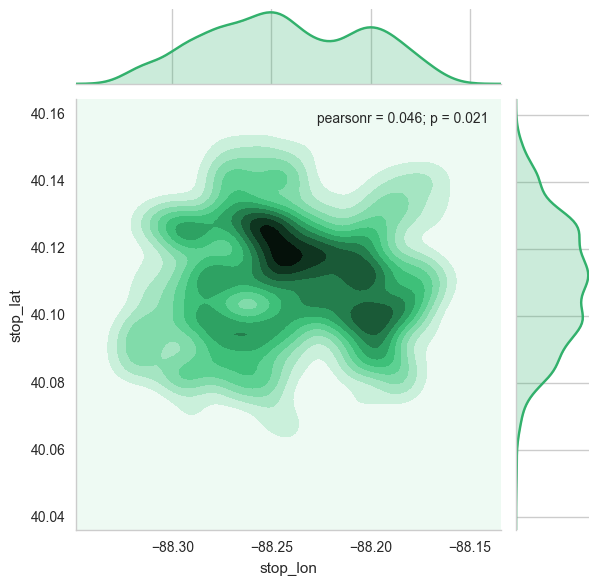

In [23]:
stops=data["stops"]
ax=sns.jointplot(x="stop_lon",y='stop_lat',data=stops,kind="kde", color="#32b16c")
# add title


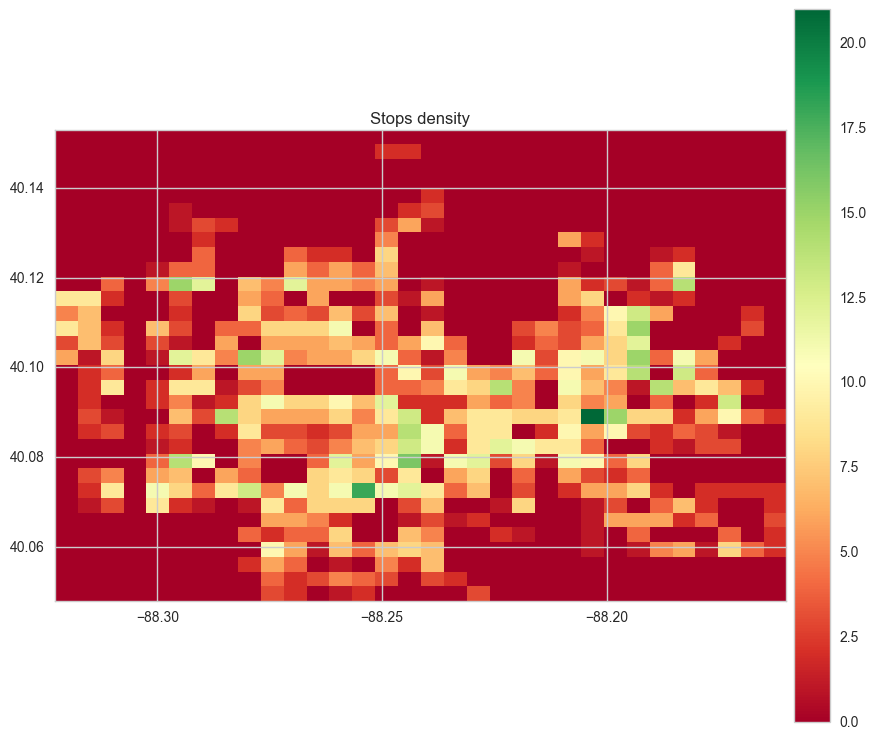

In [24]:
#ax size 
#viridis
plt.rcParams["figure.figsize"] = (10, 10)
stats=dataset.stats()
lon_min=stats["stop_lon"][0]
lon_max=stats["stop_lon"][1]
lat_min=stats["stop_lat"][0]
lat_max=stats["stop_lat"][1]
num_bins=32
lon=np.mgrid[lon_min:lon_max:(num_bins+1)*1j]
lat=np.mgrid[lat_min:lat_max:(num_bins+1)*1j]
stops_count=np.zeros((num_bins,num_bins))
for i in range(num_bins):
    left_lat=lat[i]
    right_lat=lat[i+1]
    filter_lat_left=dataset.filter_gt("stop_lat",left_lat)
    filter_lat_right=filter_lat_left.filter_lt("stop_lat",right_lat)
    for j in range(num_bins):
        left_lon=lon[j]
        right_lon=lon[j+1]
        filter_lon_left=filter_lat_right.filter_gt("stop_lon",left_lon)
        filter_lon_right=filter_lon_left.filter_lt("stop_lon",right_lon)
        stops_count[i,j]+=filter_lon_right.size()
        
plt.imshow(stops_count,extent=(lon_min,lon_max,lat_min,lat_max),cmap=plt.cm.RdYlGn,interpolation="nearest")
plt.title("Stops density")
plt.colorbar(fraction=0.046, pad=0.01)

### 1.3 Trips and stops

In [25]:
tripscount=data["stop_times"].groupby("trip_id").count()
tripssort=tripscount.sort("stop_id",ascending=False)


/Users/abbypro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



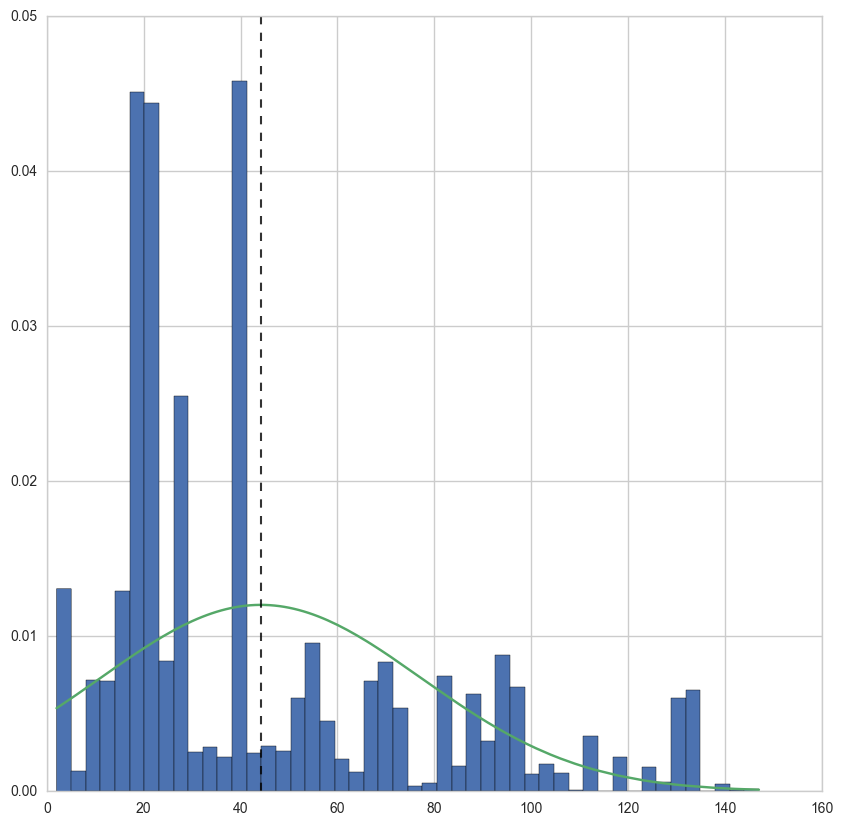

In [26]:
trip_list=tripssort["stop_id"].tolist()
plt.hist(trip_list,bins=48,normed=True)

fit = norm.pdf(trip_list, np.mean(trip_list), np.std(trip_list))  
tripsmean=np.mean(trip_list)
plt.plot(trip_list,fit,'-')
plt.axvline(x = tripsmean, color='black', linestyle='--', lw=1.5, alpha = 0.8)
# title lable
# text mean

### 1.4 Top 10 busiest stops 

In [27]:
stopid=data["stop_times"]["stop_id"]
word_counts = dict(Counter(stopid))
top_ten=dict(Counter(word_counts).most_common(10))
top_ten_keys=top_ten.keys()

In [28]:
top_ten_sorted = sorted(top_ten.items(), key=lambda x: x[1],reverse=True)
print (top_ten_sorted)

[('PAR:2', 1732), ('IU:1', 1674), ('GRNMAT:3', 1660), ('IU:2', 1629), ('GRNMAT:1', 1617), ('ARYWRT:3', 1451), ('IT:5', 1317), ('PLAZA:4', 1292), ('LSE:8', 1286), ('WRTCHAL:4', 1247)]


In [29]:
stops=data["stops"]
top10data=stops.loc[stops['stop_id'].isin(top_ten_keys)]

In [30]:
sortlist=sort_list(top_ten_sorted)

In [31]:
sortname=stop_name_list(sortlist)
print (sortname)

['PAR (North Side Shelter)', 'Illini Union (South Side Shelter)', 'Green & Mathews (SW Corner)', 'Illini Union (Engineering Side)', 'Green & Mathews (NE Corner)', 'Armory & Wright (South Side)', 'Illinois Terminal (Platform C)', 'Transit Plaza (SE Platform)', 'Lincoln Square Garage South', 'Wright & Chalmers (NW Corner)']


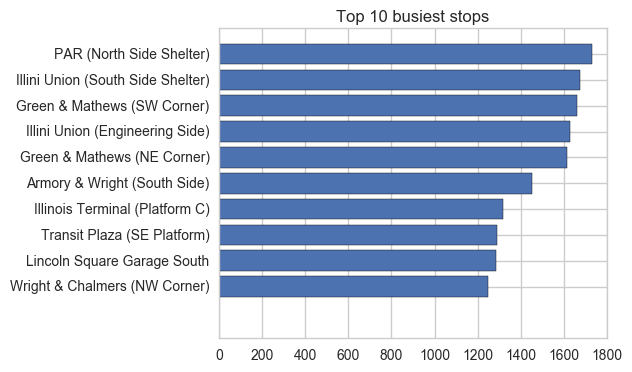

In [32]:
#ax
#label
plt.rcParams["figure.figsize"] = (5, 4)
plt.barh(range(len(top_ten)), [t[1] for t in top_ten_sorted][::-1], align='center')
plt.yticks(range(len(top_ten)), sortname[::-1],fontsize=10)
plt.title("Top 10 busiest stops")


In [33]:
min_lon10=top10data["stop_lon"].min()
max_lon10=top10data["stop_lon"].max()
min_lat10=top10data["stop_lat"].min()
max_lat10=top10data["stop_lat"].max()
lon_left10=min_lon10
lon_right10=max_lon10
lat_left10=min_lat10
lat_right10=max_lat10

zoomindata=stops.loc[(stops['stop_lon']>lon_left10)&
                     (stops['stop_lon']<lon_right10)&
                     (stops['stop_lat']>lat_left10)&
                     ((stops['stop_lat']<lat_right10))]

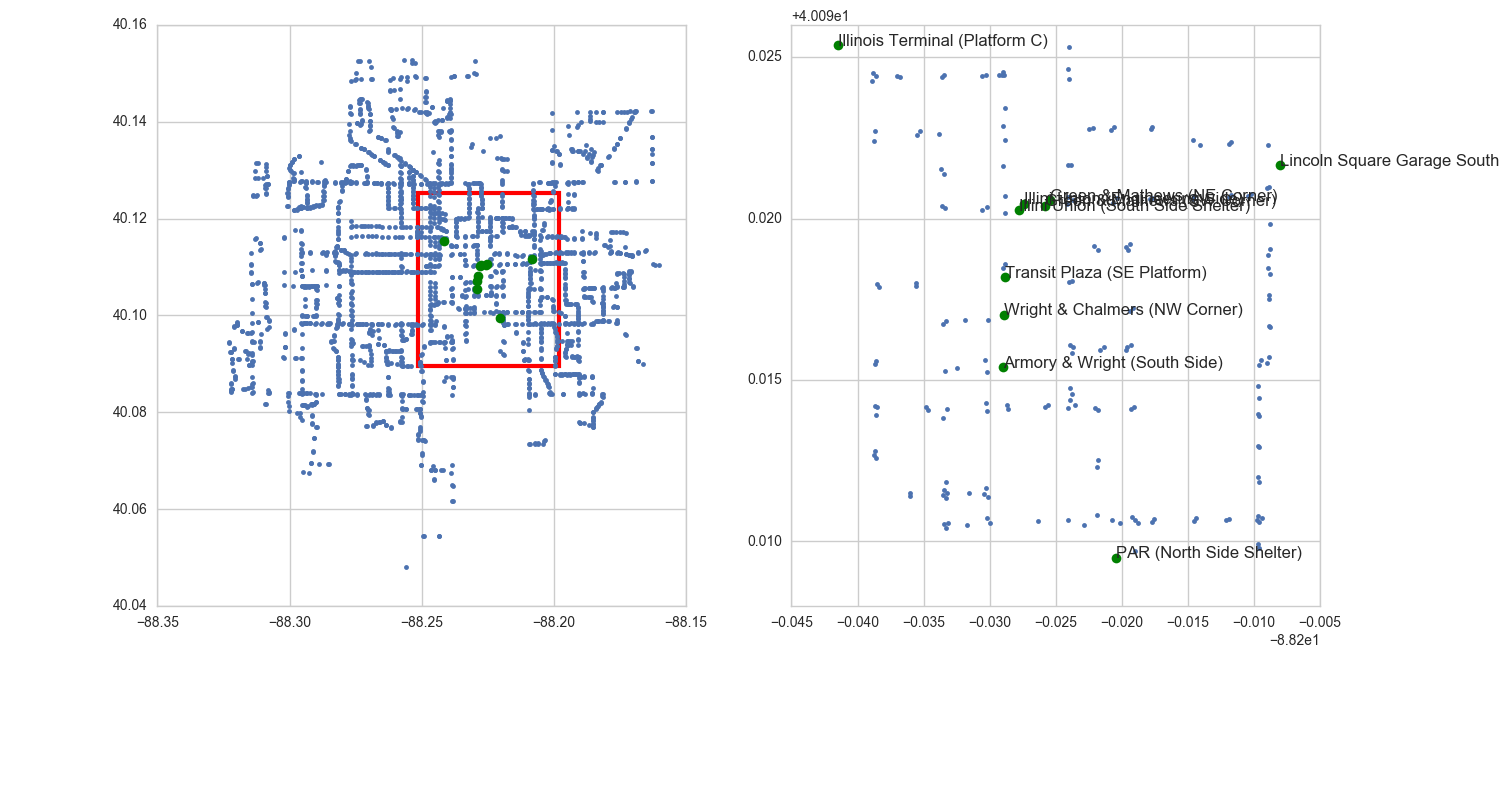

In [34]:

plt.figure(figsize=(15, 7.5))

ax1 = plt.subplot(1,2,1)
ax1.plot(data["stops"]["stop_lon"],data["stops"]["stop_lat"],".")
ax1.plot(top10data["stop_lon"],top10data["stop_lat"],"go")
ax1.annotate("PAR (North Side Shelter)",
            xy=(40.09949000000001,-88.220416), xycoords='data')


lat_width=(max_lat10-min_lat10)+0.02
lon_width=(max_lon10-min_lon10)+0.02


ax2 = plt.subplot(1,2,1)
ax2.add_patch(Rectangle((min_lon10-0.01, min_lat10-0.01), lon_width, lat_width,alpha=1,edgecolor="red",fill=False,linewidth=3))

ax3 = plt.subplot(1,2,2)
ax3.plot(zoomindata["stop_lon"],zoomindata["stop_lat"],".")
ax3.plot(top10data["stop_lon"],top10data["stop_lat"],"go")

for i in top_ten_keys:    
    ax3.annotate(get_stop_name(i), xy=get_stop_latlon(i))



plt.show()
#circle the middle area
#zoom in the stops



## 2. Buses per Route

In [35]:
routes =data["trips"].route_id

In [36]:
data["trips"].keys()

Index(['route_id', 'service_id', 'trip_id', 'trip_headsign', 'direction_id',
       'block_id', 'shape_id'],
      dtype='object')

In [37]:
route_list = np.unique(data['trips'].route_id).tolist()

n_buses = []
for idx, route in enumerate(np.unique(data["trips"].route_id)):
    selected_block_id = data['trips'][routes == route].block_id
    n_buses.append(len(np.unique(selected_block_id)))

route_clrs = [get_route_color(r) for r in route_list]

bus_dict = {'route_list': route_list, 'n_buses': n_buses, 'route_clrs': route_clrs}
bus = pd.DataFrame(data=bus_dict)

# sort bus
bus = bus.sort(['route_clrs', 'n_buses'], ascending=[True, True])
print(bus)

    n_buses route_clrs                       route_list
64        1    #000000                            RAVEN
87        2    #006991         TEAL LATE NIGHT SATURDAY
88        2    #006991           TEAL LATE NIGHT SUNDAY
86        3    #006991                  TEAL LATE NIGHT
85        4    #006991            TEAL EVENING SATURDAY
90        4    #006991                      TEAL SUNDAY
84        5    #006991                     TEAL EVENING
89        6    #006991                    TEAL SATURDAY
83        8    #006991                             TEAL
8         1    #008063                   5W GREEN ALT 2
30        1    #008063          GREEN LATE NIGHT SUNDAY
6         2    #008063           5E GREEN EXPRESS 1 ALT
29        2    #008063        GREEN LATE NIGHT SATURDAY
7         3    #008063             5E GREEN EXPRESS ALT
9         3    #008063               5W GREEN EXPRESS 2
27        3    #008063                GREEN EXPRESS ALT
28        3    #008063                 GREEN LAT

/Users/abbypro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



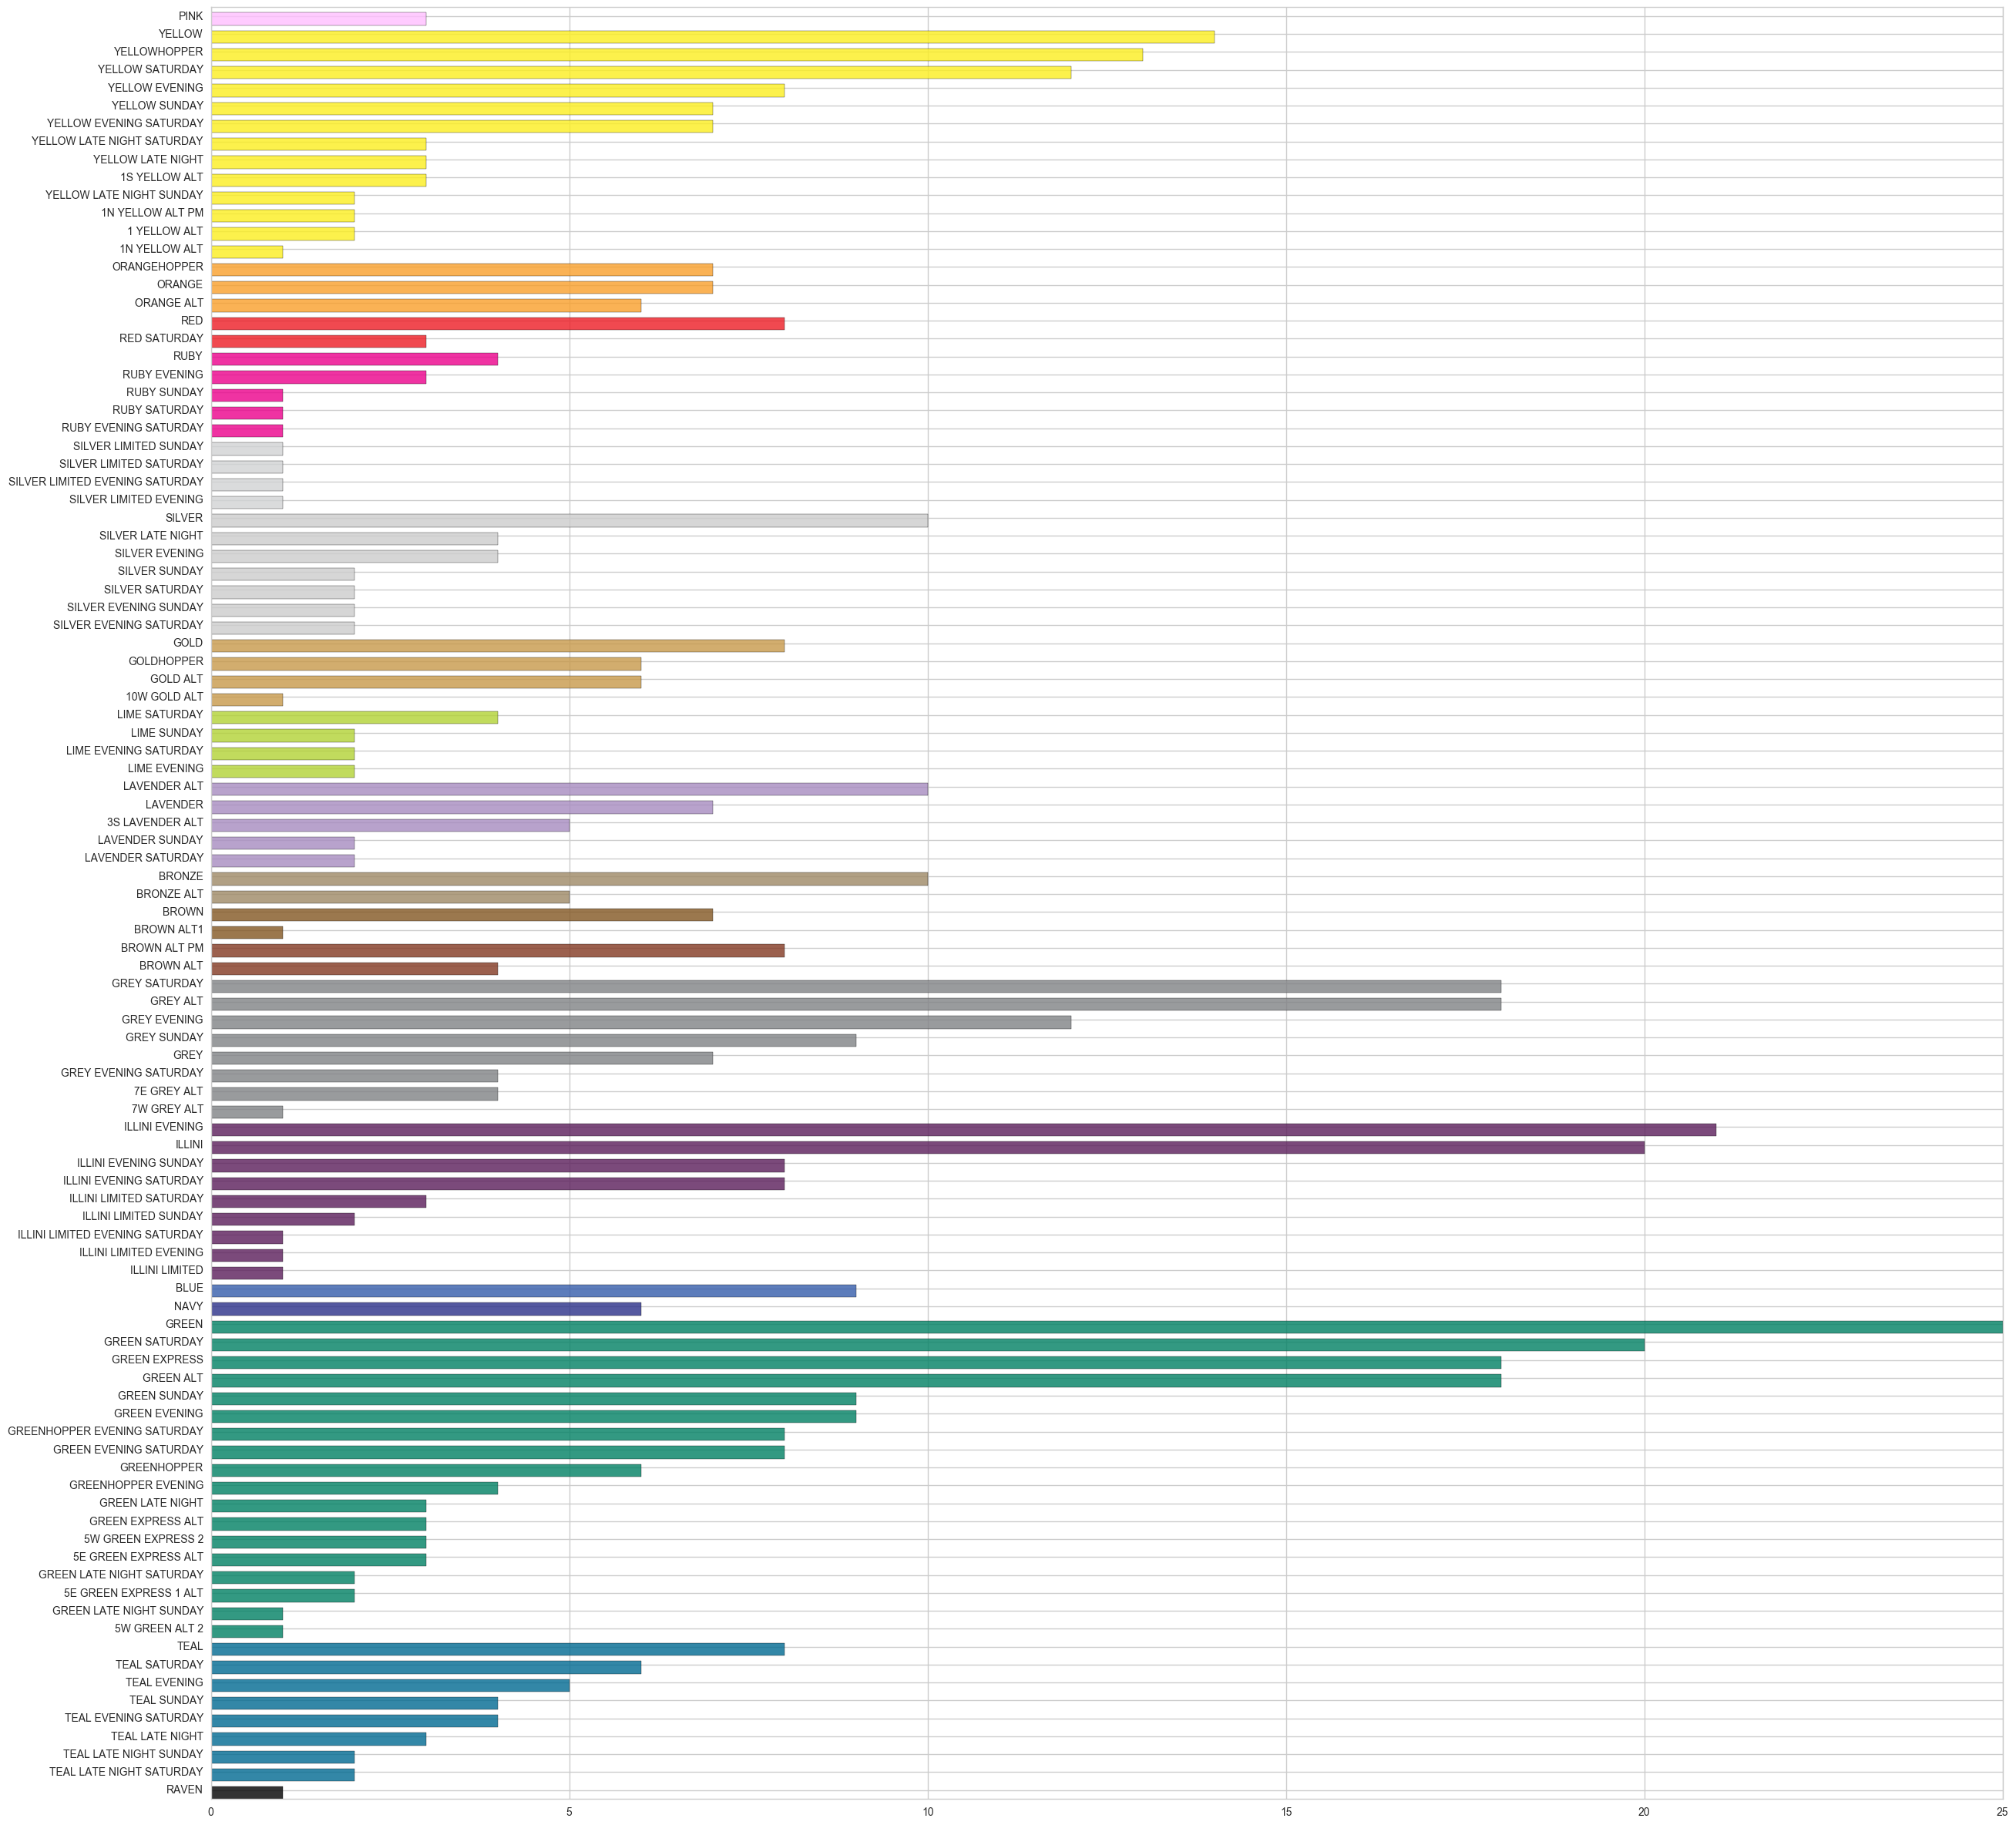

In [38]:
# 1. grouby routecolor 
# 2. sorted within groups

fig, ax = plt.subplots(figsize = (30,30))
x = bus.n_buses
N = len(x)
y = list(range(N))
y_ticks = [i+0.5 for i in y]
ax.barh(y,x,
        color = bus.route_clrs, height = 0.7, alpha = 0.8)
ax.set_yticks(y_ticks)
ax.set_yticklabels(bus.route_list)


## 3. Bus Speed

In [39]:
match_weekend = re.compile(r'(SATURDAY|SUNDAY)')
match_eve = re.compile(r'EVENING')
match_alt = re.compile(r'ALT')
match_express = re.compile(r'EXPRESS')

weekend = []
eve = []
alt = []
regular = []
express = []
all_routes = get_routes_speed_by_type(routes = data['routes']['route_id'].unique().tolist())[0]

for route in all_routes:
    for word in route.split():
        if re.match(match_weekend,word):
            weekend.append(route)
        elif re.match(match_eve,word):
            eve.append(route)
        elif re.match(match_alt,word):
            alt.append(route)
        elif re.match(match_express,word):
            express.append(route)

for route in all_routes:
    if route not in set(weekend+eve+alt+express):
        regular.append(route)

In [40]:
fmt_str = 'Routes in {0}: {1}'
print(fmt_str.format('Weekend', len(weekend)))
print('-'*30)
print(fmt_str.format('Evening', len(eve)))
print('-'*30)
print(fmt_str.format('Alt', len(alt)))
print('-'*30)
print(fmt_str.format('Express', len(express)))
print('-'*30)
print(fmt_str.format('Regular', len(regular)))
print('-'*30)
print(fmt_str.format('All', len(all_routes)))
print('-'*30)

Routes in Weekend: 40
------------------------------
Routes in Evening: 24
------------------------------
Routes in Alt: 14
------------------------------
Routes in Express: 3
------------------------------
Routes in Regular: 25
------------------------------
Routes in All: 92
------------------------------


In [41]:
def bar_chart_by_type(routes, title = 'All Routes', ax = ax, k = 1):
    
    routes_selected, route_speeds = get_routes_speed_by_type(routes)
    
    sns.set_style("white")

    clrs = [get_route_color(r) for r in routes_selected]
    mean_speed = sum(route_speeds)/len(route_speeds)

    x = route_speeds
    N = len(x)
    y = list(range(N))
    y_ticks = [i+0.5 for i in y]
    
    ax.set_ylim(0,1)
    ax.barh(y, x, color = clrs, height = 0.7, alpha = 0.8)
    ax.axvline(x = mean_speed, color='black', linestyle='--', lw=1.5, alpha = 0.8)
    ax.text(mean_speed + 10*k, 10*k, 'mean speed: \n{0:5.2f} m/min'.format(mean_speed), fontsize = 18*k)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(routes_selected)
    ax.tick_params(labelsize = 10*k)
    ax.set_title('Average Speed By Route: {}'.format(title), fontsize = 22*k)
    ax.set_xlabel('Route Speed (m/min)', fontsize = 18*k)
    ax.set_ylabel('Route', fontsize = 18*k)

    sns.despine(trim = True, offset = 0)

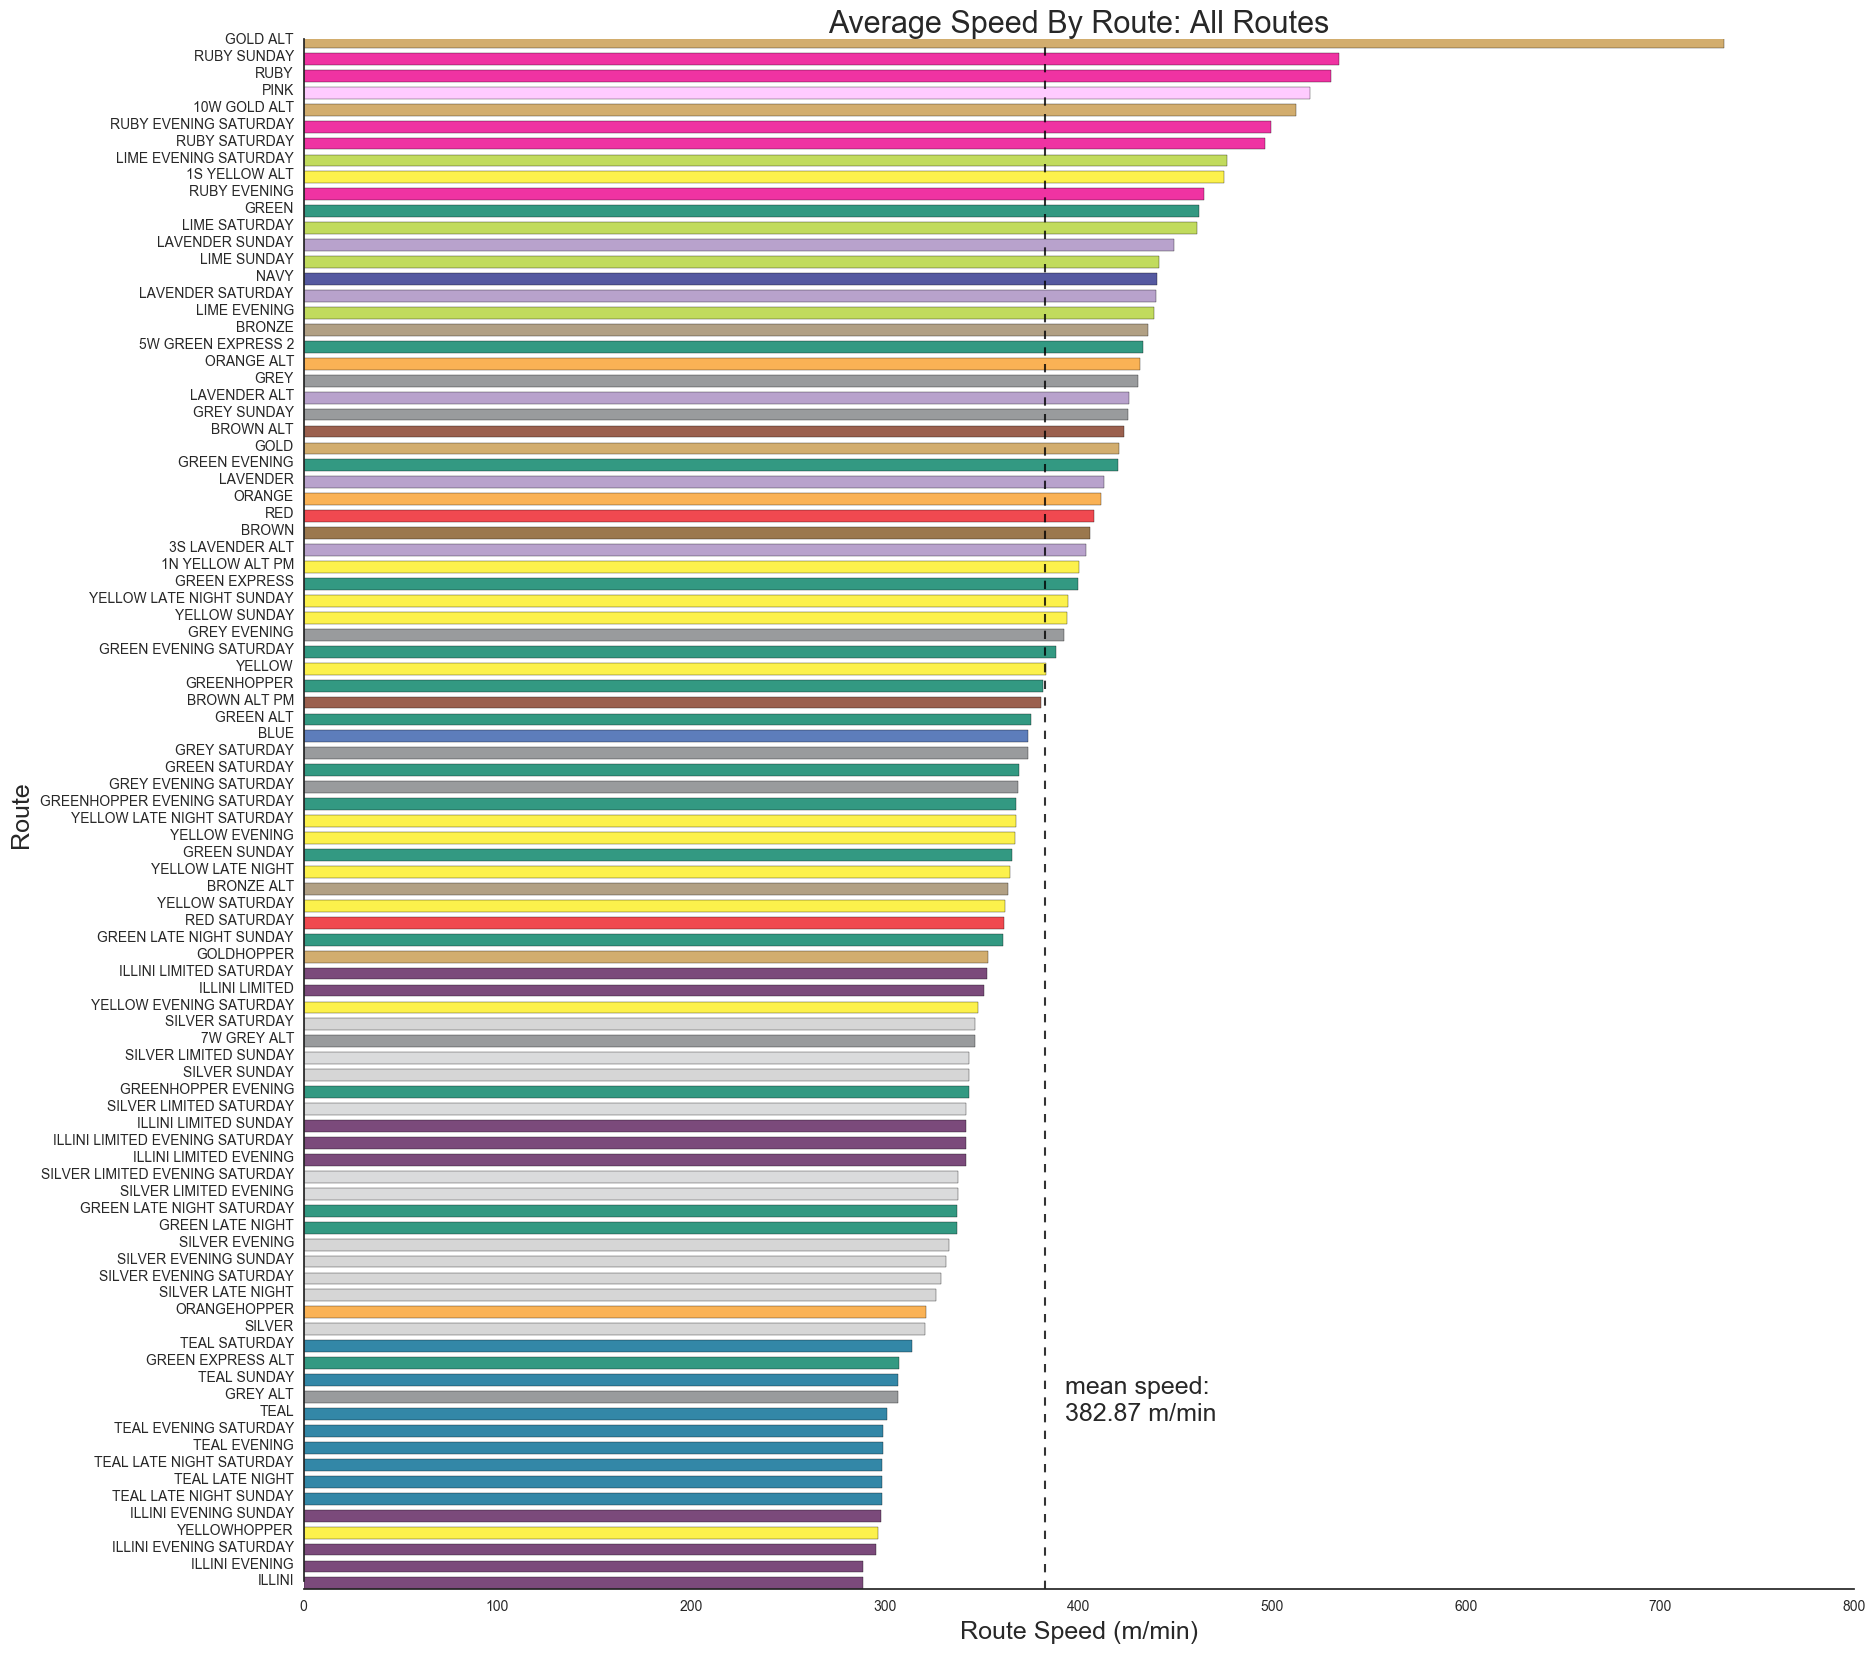

In [54]:
fig, ax = plt.subplots(figsize = (20,20))
ax.set_title('Average Speed By Route: {}'.format('All Routes'), fontsize = 22)
bar_chart_by_type(routes = data['routes']['route_id'].unique().tolist(), ax = ax)
#fig.savefig('bar_chart_1.png', transparent = True)

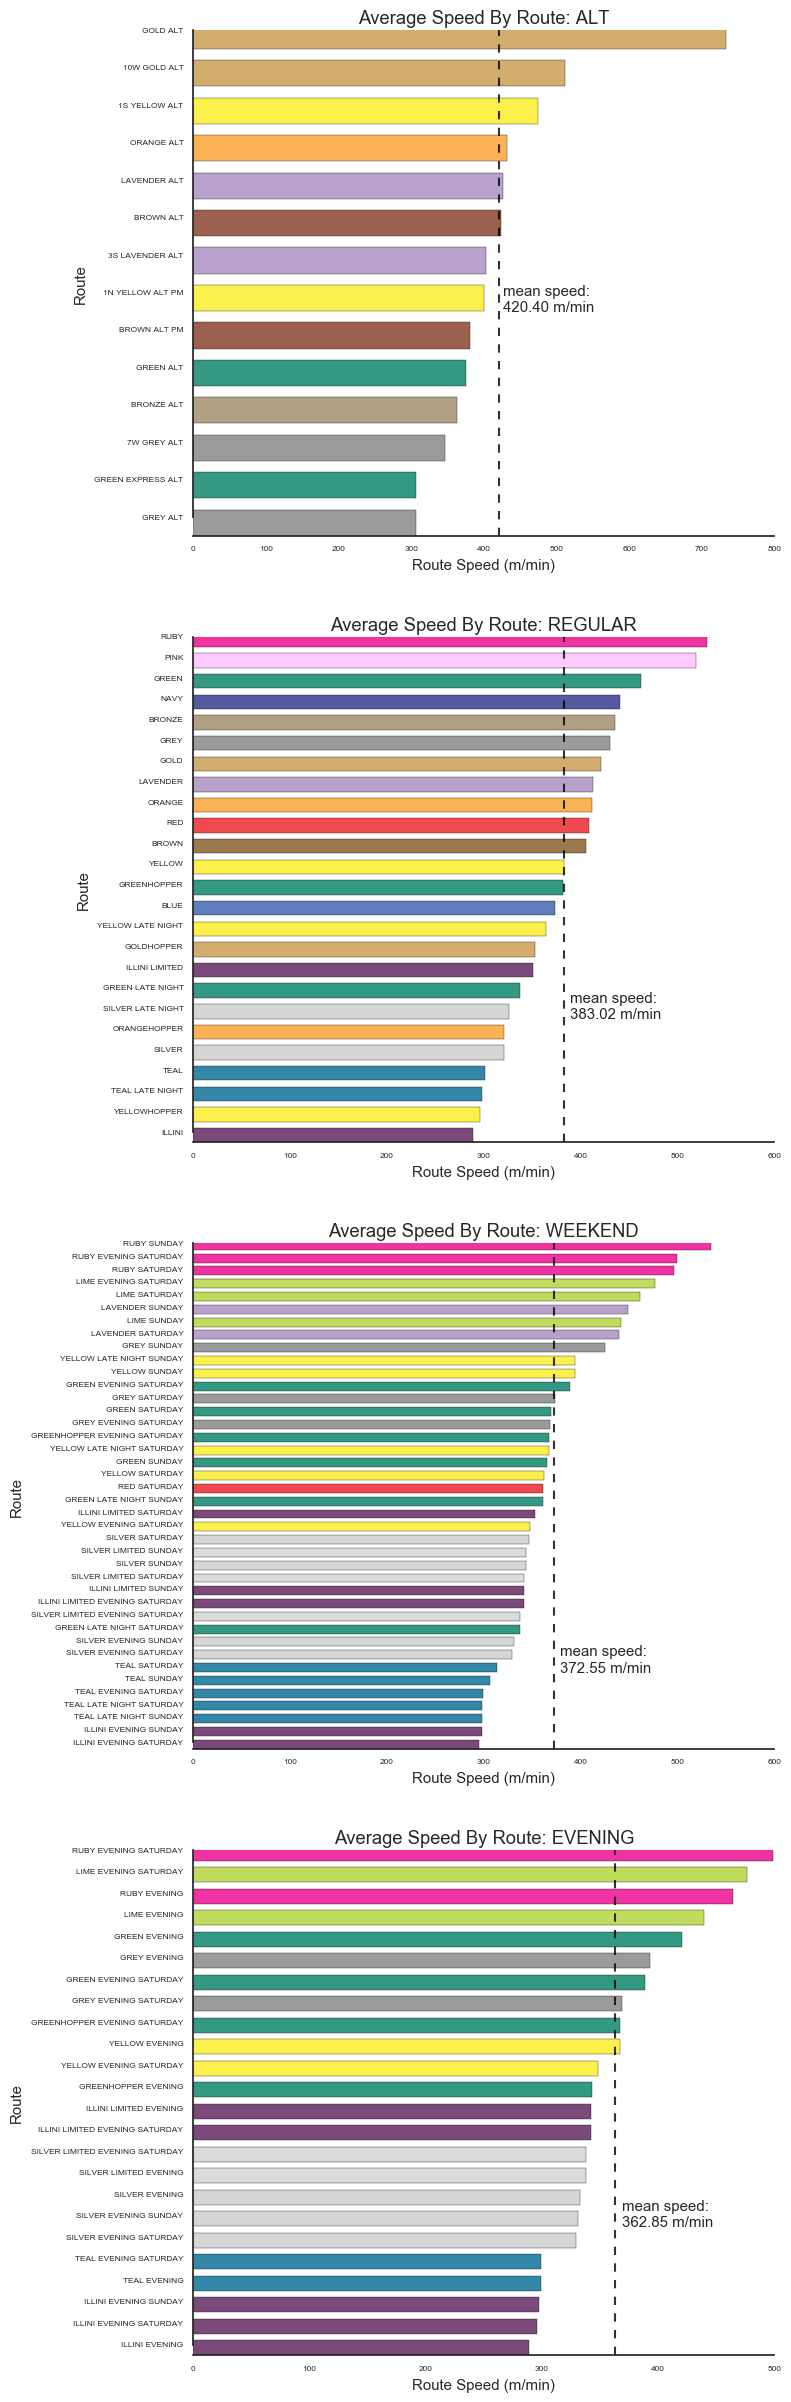

In [53]:
# make the main figure
fig = plt.figure(1)
plt.suptitle("Average Speeds of Different Types of Routes", fontsize = 28)
plt.rcParams["figure.figsize"] = (40, 40)

# make the subplots
k = 0.6
plt.figure(figsize=(7.5, 30))
ax1 = plt.subplot(4,1,1)
bar_chart_by_type(routes = alt, title = 'ALT', ax = ax1, k = k)
ax2 = plt.subplot(4,1,2)
bar_chart_by_type(routes = regular, title = 'REGULAR', ax = ax2, k = k)
ax3 = plt.subplot(4,1,3)
bar_chart_by_type(routes = weekend, title = 'WEEKEND', ax = ax3, k = k)
ax4 = plt.subplot(4,1,4)
bar_chart_by_type(routes = eve, title = 'EVENING', ax = ax4, k = k)
#plt.savefig('bar_chart_4.png',transparent = True)

#### Use Plotly to Create a Stop Network

In [56]:
# plotly credential
plotly.tools.set_credentials_file(username='lzeng6', api_key='sET35IN6zBEbv5lZaT9M')

In [64]:
# Route TEAL
route = 'TEAL'
# create network graph
direction = 1
clr = get_route_color(route)
g = create_graph_by_route(route = route, direction = direction)
stoplist = get_stops_on_route(route, direction = direction)
       
# the positions of all nodes
pos = get_stops_positions(stoplist)

# add edges
edge_trace = Scatter(
    x=[],
    y=[],
    hoverinfo='none',
    mode='lines',
    line=dict(
        color=clr,
        width=1,
    ))

weights = {}
for n1, n2, dct in g.edges(data=True):
    x0, y0 = pos[n1]
    x1, y1 = pos[n2]
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]
    weights[n2] = dct['weight'] 

# add nodes
node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    textposition='top center',
    mode='markers+text',
    hoverinfo='text',
    marker=Marker(
        color= clr,
        size= [],
        line=dict(width=1, color = 'black')))

for node in g.nodes():
    x, y = pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    if weights.get(node,0) != 0:
        node_info = weights.get(node,0)

        if node_info > 1:
            node_trace['text'].append('{0}:<br>{1:5.2f} mins'.format(get_stop_name(node),node_info))
                                      
        node_trace['marker']['size'].append(node_info*10)
    else:
        node_trace['marker']['size'].append(0.1)
        
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>CUMTD Stops Network: Route {0}'.format(route),
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')

In [66]:
# Route RUBY
route = 'RUBY'
# create network graph
direction = 1
clr = get_route_color(route)
g = create_graph_by_route(route = route, direction = direction)
stoplist = get_stops_on_route(route, direction = direction)
       
# the positions of all nodes
pos = get_stops_positions(stoplist)

# add edges
edge_trace = Scatter(
    x=[],
    y=[],
    hoverinfo='none',
    mode='lines',
    line=dict(
        color=clr,
        width=1,
    ))

weights = {}
for n1, n2, dct in g.edges(data=True):
    x0, y0 = pos[n1]
    x1, y1 = pos[n2]
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]
    weights[n2] = dct['weight'] 

# add nodes
node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    textposition='top center',
    mode='markers+text',
    hoverinfo='text',
    marker=Marker(
        color= clr,
        size= [],
        line=dict(width=1, color = 'black')))

for node in g.nodes():
    x, y = pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    if weights.get(node,0) != 0:
        node_info = weights.get(node,0)

        if node_info > 0.5:
            node_trace['text'].append('{0}:<br>{1:5.2f} mins'.format(get_stop_name(node),node_info))
                                      
        node_trace['marker']['size'].append(node_info*10)
    else:
        node_trace['marker']['size'].append(0.1)
        
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>CUMTD Stops Network: Route {0}'.format(route),
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')